In [1]:
# import os
# import base64
# import json
# from openai import OpenAI
# from dotenv import load_dotenv
# from PIL import Image

# # ---- Config ----
# PLACEHOLDER_IMG = "infographic.png"        # finalized infographic
# QR_IMG_PATH    = "uploaded/product_link.png"        # real QR code image
# OUTPUT_IMG     = "infographic_final.png"  # output path
# MODEL_NAME     = "gpt-4.1"

# # ---- Helpers ----
# def encode_image(image_path: str) -> str:
#     """Return Base64 string of the image."""
#     with open(image_path, "rb") as f:
#         return base64.b64encode(f.read()).decode("utf-8")


# def detect_qr_bounding_box(client, image_path: str) -> dict:
#     """
#     Uses an LLM to detect a QR code bounding box in the image.
#     Returns either:
#       { "bounding_box": False }
#     or
#       { "bounding_box": True,
#         "x_pct": 0.123, "y_pct": 0.456,
#         "w_pct": 0.100, "h_pct": 0.100 }
#     where percentages are relative to the image dimensions.
#     """
#     # Read and encode image
#     b64 = encode_image(image_path)
#     # Image size
#     img = Image.open(image_path)
#     W, H = img.size

#     prompt = f"""
#     You are an expert image-analysis assistant. The image is {W} pixels wide and {H} pixels tall.
#     Determine if it contains a placeholder frame at the bottom representing the QR code position.
#     Return only JSON with:
#     {{
#     "bounding_box": <true|false>,
#     "x_pct": <0–1>,   # left fraction, if true
#     "y_pct": <0–1>,   # top fraction,  if true
#     "w_pct": <0–1>,   # width fraction,  if true
#     "h_pct": <0–1>    # height fraction, if true
#     }}
#     If no placeholder frame is detected, output {{"bounding_box": false}} with no other keys.
#     """.strip()

#     response = client.responses.create(
#         model=MODEL_NAME,
#         input=[{
#             "role": "user",
#             "content": [
#                 {"type": "input_text", "text": prompt},
#                 {"type": "input_image", "image_url": f"data:image/png;base64,{b64}"}
#             ]
#         }]
#     )
#     return json.loads(response.output_text)


# def replace_qr_using_coords(
#     infographic_path: str,
#     coords: dict,
#     qr_path: str,
#     output_path: str
# ):
#     """
#     Replaces the QR placeholder at relative coords with the actual QR,
#     preserving the QR's aspect ratio and centering it within the bounding box.
#     Coords must contain x_pct, y_pct, w_pct, h_pct.
#     """
#     if not coords.get("bounding_box", False):
#         raise ValueError("No QR detected; bounding_box is false.")

#     # Load base image
#     base = Image.open(infographic_path).convert("RGBA")
#     W, H = base.size

#     # Convert relative to absolute pixel values
#     x = int(coords["x_pct"] * W)
#     y = int(coords["y_pct"] * H)
#     w = int(coords["w_pct"] * W)
#     h = int(coords["h_pct"] * H)

#     # Load QR and preserve aspect ratio
#     qr = Image.open(qr_path).convert("RGBA")
#     qr_w, qr_h = qr.size
#     scale = min(w / qr_w, h / qr_h)
#     new_w = int(qr_w * scale)
#     new_h = int(qr_h * scale)
#     qr_resized = qr.resize((new_w, new_h))

#     # Center within placeholder
#     offset_x = x + (w - new_w) // 2
#     offset_y = y + (h - new_h) // 2

#     # Paste and save
#     base.paste(qr_resized, (offset_x, offset_y), qr_resized)
#     base.save(output_path)
#     print(f"✅ Saved final infographic to {output_path} at bbox ({offset_x},{offset_y},{new_w},{new_h})")

In [2]:
# load_dotenv()
# client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# # 1) Detect QR location (relative)
# coords = detect_qr_bounding_box(client, PLACEHOLDER_IMG)
# print("Detected coords:", coords)

# # 2) Replace QR using absolute mapped coords
# replace_qr_using_coords(
#     infographic_path=PLACEHOLDER_IMG,
#     coords=coords,
#     qr_path=QR_IMG_PATH,
#     output_path=OUTPUT_IMG
# )

In [3]:
import cv2
import numpy as np
from PIL import Image
import io
import base64


def detect_placeholder_box(image_path: str) -> tuple[int,int,int,int]:
    """
    1) Load the image, Canny-edge detect and dilate edges.
    2) Find all contours.
    3) Approximate each to a polygon; pick the 4-point contour with the largest area
       that lives in the bottom half of the canvas.
    Returns (x, y, w, h) of its bounding rect.
    """
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    edges = cv2.dilate(edges, np.ones((3,3),np.uint8), iterations=1)

    cnts, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    H, W = gray.shape
    best = (0,0,0,0,0)  # area, x, y, w, h

    for c in cnts:
        area = cv2.contourArea(c)
        if area < (W*H*0.01):
            continue
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            x,y,w,h = cv2.boundingRect(approx)
            if y > H*0.4 and area > best[0]:
                best = (area, x, y, w, h)

    if best[0] == 0:
        raise RuntimeError("Placeholder rectangle not found.")

    _, x, y, w, h = best
    return x, y, w, h


def replace_qr_in_placeholder(
    infographic_path: str,
    qr_path: str
) -> str:
    """
    1) Detects the placeholder box in the infographic.
    2) Loads and resizes the QR code image to the placeholder size.
    3) Pastes the QR over the placeholder.
    4) Returns the final image as a Base64-encoded PNG string.
    """
    # Detect placeholder
    x, y, w, h = detect_placeholder_box(infographic_path)

    # Open images
    base = Image.open(infographic_path).convert("RGBA")
    qr   = Image.open(qr_path).convert("RGBA")

    # Resize QR
    qr_resized = qr.resize((w, h), Image.LANCZOS)

    # Paste QR
    base.paste(qr_resized, (x, y), qr_resized)

    # Convert to Base64
    buffered = io.BytesIO()
    base.save(buffered, format="PNG")
    b64_img = base64.b64encode(buffered.getvalue()).decode("utf-8")

    return b64_img

In [ ]:
b64 = replace_qr_in_placeholder(
    infographic_path="infographic.png",
    qr_path="uploaded/product_link.png"
)

iVBORw0KGgoAAAANSUhEUgAABAAAAAYACAYAAADogjqqAAEAAElEQVR4nGz9i5VcWa5sC0aQ2aq0Ek+H1l+YCrLHgs1pgPO8urdOZZIR7nuvD2AwGIDv/+//8//7+/X+8+vr6+vv36+/f76+vn99z7/+fH19ff/9+/X1/f73++vv+++vP1+/5jd+ff2Z3/kzP/P3+/vr++/X19/3s1+/vr6//ub/za9/z1fM5+Rrvr74+T9f+fr5nq+vrz/fX1+/fv36+vXz5+vPr+880/tZf+77++vve7D33fML7+//5s/5o/cPv76/57P7fX2K91T5nG//jed5P/j+7M/f8/ff7x2+v77zsPnw37++vv/8/fozP/Pe4+++x/evr6/vP/nZ+cJ867zBfO586NffWd33j9/87F8egXedd3+/9z473/F+gO2Yn8/fvuf6lc+dX8jvv32YveTPZ33eWrEJv7+/vn7mfdkbnnTW6leW963DfEgORz6MTZ59/uPvvLd/z5CfzfO9Z80i/H1//vd79vXvnz98+FvT7gbPNxvavdxn+Pr6y37nSfq37Pd7mPcmf77+8P28af93VmXOSp453+G75xnyv3tW8ul/5+z3rLw//c79yLa9b33PnxPw6x3g319ff3/4TBeV/exeuOCeqfnZ9+xz63Luf313jX/yBnMeWeH5vTmrvs9sUd54vpKlyX3je7gbPEruzrzHr5z1Pzzf/Dnr8OfP1/evX/l5XiXLni/PmeVo5ND23HuG/76zNvvvg70f+TWf/XvOSB/Iv+o6zK6Ovfge+/B+9K3Bnw/7kr2bPXhXas4Xz/L+5z3+ewbOyjwph+H9ebaHe8a69d6+Z/7N1s8+/Wjovv7mg79+fb+9yIq5pu9zXZt5J+zjPF/Pd9Z59vW9HwvcW/mu9/ffr9+zttw7DUn+5ev73b93QWaLcvGfHcq6Y0F4iPnVLNA8+1vFWc15pjxgPv/t5K/sw3kHHISWJyuEofl5V9sH

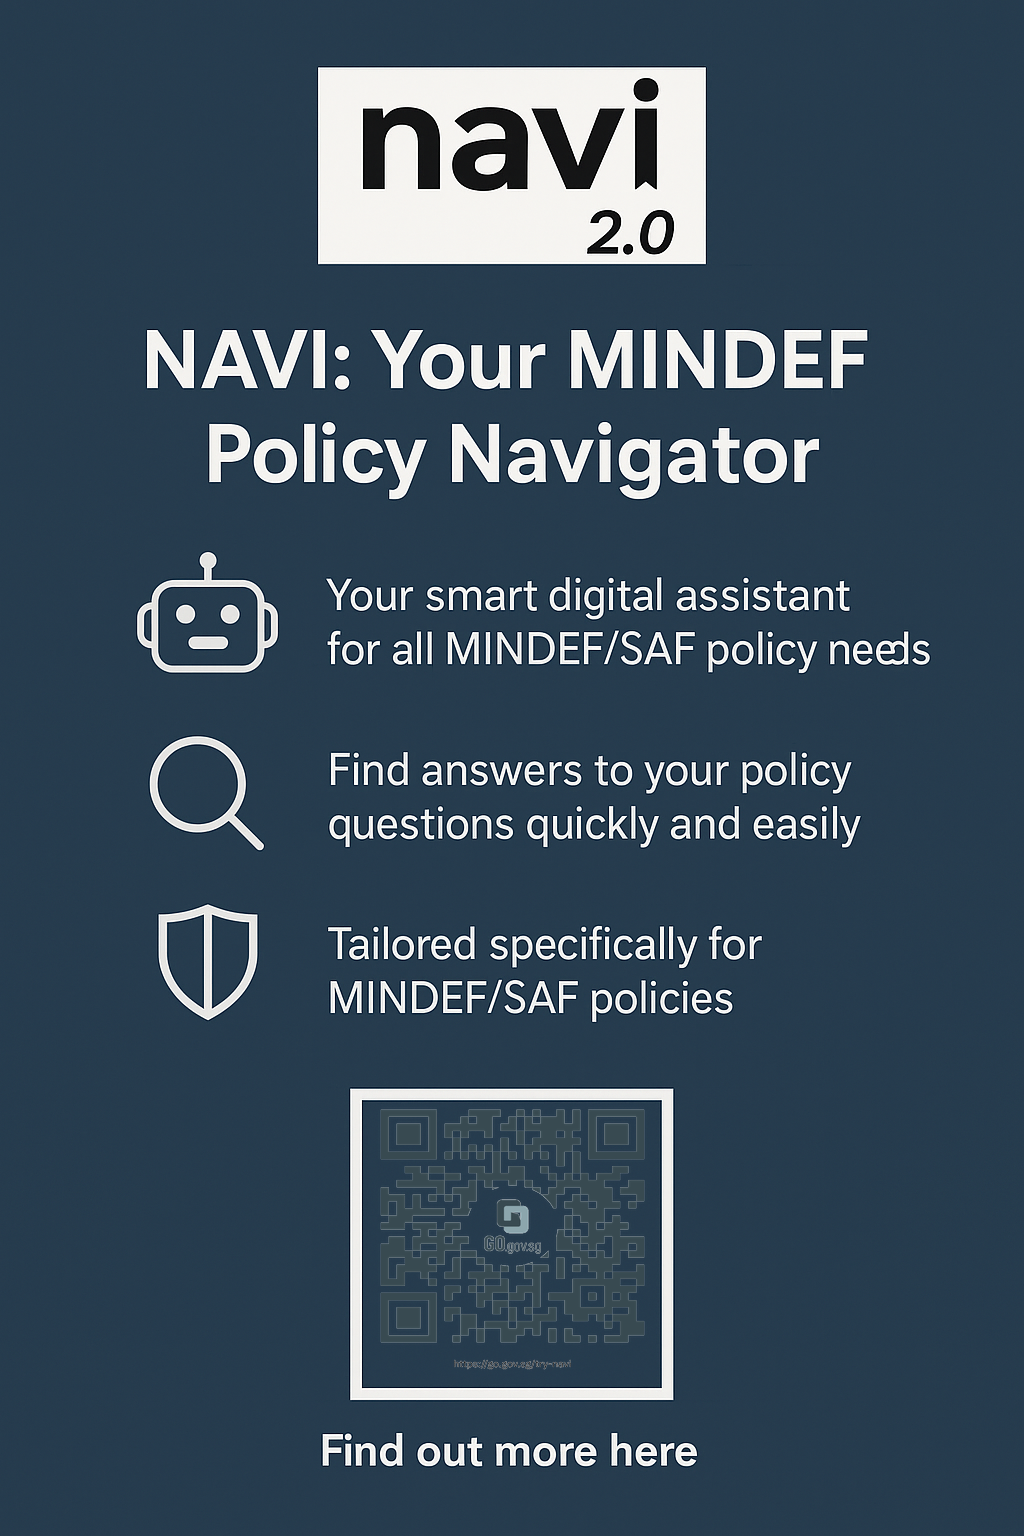

In [5]:
import base64
from IPython.display import Image, display

display(Image(data=base64.b64decode(b64)))